In [1]:
import os
from collections import Counter
import numpy as np
import scipy.sparse as sps
from scipy.linalg import pinv
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.utils.class_weight import compute_sample_weight

def save_array(array, filename, sep=',', subdir='data'):
    """Saves a Numpy array as a delimited text file.
    Args:
        array (Numpy.Array): Input array.
        filename (str): Output file name.
        sep (str): Delimiter.
        subdir (str): Parent directory path for output file.
    """
    tdir = os.path.join(os.getcwd(), os.pardir, subdir, filename)
    np.savetxt(fname=tdir, X=array, delimiter=sep, fmt='%.20f')

def save_dataset(df, filename, sep=',', subdir='data', header=True):
    """Saves Pandas data frame as a CSV file.
    Args:
        df (Pandas.DataFrame): Data frame.
        filename (str): Output file name.
        sep (str): Delimiter.
        subdir (str): Project directory to save output file.
        header (Boolean): Specify inclusion of header.
    """
    tdir = os.path.join(os.getcwd(), os.pardir, subdir, filename)
    df.to_csv(path_or_buf=tdir, sep=sep, header=header, index=False)

def get_abspath(filename, filepath):
    """Gets absolute path of specified file within the project directory. The
    filepath has to be a subdirectory within the main project directory.
    Args:
        filename (str): Name of specified file.
        filepath (str): Subdirectory of file.
    Returns:
        fullpath (str): Absolute filepath.
    """
    p = os.path.abspath(os.path.join(os.curdir, os.pardir))
    fullpath = os.path.join(p, filepath, filename)

    return fullpath

def balanced_accuracy(labels, predictions):
    """Modifies the standard accuracy scoring function to account for
    potential imbalances in class distributions.
    Args:
        labels (numpy.array): Actual class labels.
        predictions (numpy.array): Predicted class labels.
    Returns:
        Modified accuracy scoring function.
    """
    weights = compute_sample_weight('balanced', labels)
    return accuracy_score(labels, predictions, sample_weight=weights)

def cluster_acc(Y, clusterY):
    """Calculates accuracy of labels in each cluster by comparing to the
    actual Y labels.
    Args:
        Y (Numpy.Array): Actual labels.
        clusterY (Numpy.Array): Predicted labels per cluster.
    Returns:
        score (float): Accuracy score for given cluster labels.
    """
    assert Y.shape == clusterY.shape
    pred = np.empty_like(Y)
    for label in set(clusterY):
        mask = clusterY == label
        sub = Y[mask]
        target = Counter(sub).most_common(1)[0][0]
        pred[mask] = target
    return balanced_accuracy(Y, pred)

def reconstruction_error(projections, x):
    """Calculates reconstruction error on a given set of projected data based
    on the original dataset.
    Args:
        projections (Numpy.Array): Random matrix used for projections.
        x (Numpy.Array): Original dataset.
    Returns:
        errors (Numpy.Array): Reconstruction error.
    """
    W = projections.components_
    if sps.issparse(W):
        W = W.todense()
    p = pinv(W)
    reconstructed = np.dot(np.dot(p, W), x.T).T  # Unproject projected data
    errors = np.square(x - reconstructed)
    return np.nanmean(errors)

def pairwise_dist_corr(x1, x2):
    """Calculates the pairwise distance correlation between two arrays.
    Args:
        x1 (Numpy.Array): First array.
        x2 (Numpy.Array): Second array.
    Returns:
        Numpy.Array of pairwise distance correlations.
    """
    assert x1.shape[0] == x2.shape[0]

    d1 = pairwise_distances(x1)
    d2 = pairwise_distances(x2)
    return np.corrcoef(d1.ravel(),d2.ravel())[0,1]


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt
import timeit

np.random.seed(0)

cc_train = pd.read_csv('cc_train.csv')
df = cc_train.apply(pd.to_numeric) 

X_train_cc = df.drop('data.default.payment.next.month',axis=1)
y_train_cc= df['data.default.payment.next.month']

ccX = X_train_cc
ccY = y_train_cc

Running ICA experiments
Completed ICA experiments in 0.22585381800308824 seconds


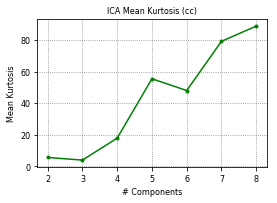

In [3]:
print ('Running ICA experiments')

start_time = timeit.default_timer()
clusters = [2,3,4,5,6,7,8]
dims = [2,3,4,5,6,7,8]

def save_ica_results(X, name, dims):
    """Run ICA and save projected dataset as CSV.
    Args:
        X (Numpy.Array): Attributes.
        name (str): Dataset name.
        dims (int): Number of components.
    """
    # transform data using ICA
    ica = FastICA(random_state=0, max_iter=5000)
    res = ica.fit_transform(X)
    
    # save results file
    resdir = 'Assignment 3'
    resfile = get_abspath('{}_ICA.csv'.format(name), resdir)
    save_array(array=res, filename=resfile)

save_ica_results(ccX, 'cc', dims)

X=ccX
name = 'cc'
ica = FastICA(random_state=0, max_iter=5000)
kurt = {}

for dim in dims:
    ica.set_params(n_components=dim)
    tmp = ica.fit_transform(X)
    df = pd.DataFrame(tmp)
    df = df.kurt(axis=0)
    kurt[dim] = df.abs().mean()

res = pd.DataFrame.from_dict(kurt, orient='index')
res.rename(columns={0: 'kurtosis'}, inplace=True)
res['n'] = res.index

df = res

# get figure and axes
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 3))

# plot explained variance and cumulative explain variance ratios
x = df['n']
kurt = df['kurtosis']
ax.plot(x, kurt, marker='.', color='g')
ax.set_title('ICA Mean Kurtosis ({})'.format(name))
ax.set_ylabel('Mean Kurtosis')
ax.set_xlabel('# Components')
ax.grid(color='grey', linestyle='dotted')

 # change layout size, font size and width
fig.tight_layout()
for ax in fig.axes:
    ax_items = [ax.title, ax.xaxis.label, ax.yaxis.label]
    for item in ax_items + ax.get_xticklabels() + ax.get_yticklabels():
        item.set_fontsize(8)

end_time = timeit.default_timer()
elapsed = end_time - start_time
print ("Completed ICA experiments in {} seconds".format(elapsed))

In [6]:
np.random.seed(0)

mushroom_train = pd.read_csv('mushroom_train.csv')
df = mushroom_train.apply(pd.to_numeric) 

X_train_mushroom = df.drop('classp',axis=1)
y_train_mushroom = df['classp']

mushroomX = X_train_mushroom
mushroomY = y_train_mushroom

print ('Running ICA experiments')

start_time = timeit.default_timer()
clusters = [2,3,4,5,6,7,8]
dims = [2,3,4,5,6,7,8]



Running ICA experiments


/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Completed ICA experiments in 50.05137275997549 seconds


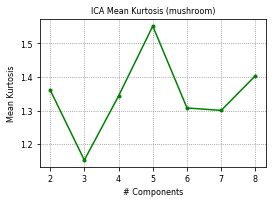

In [8]:
def save_ica_results(X, name, dims):
    """Run ICA and save projected dataset as CSV.
    Args:
        X (Numpy.Array): Attributes.
        name (str): Dataset name.
        dims (int): Number of components.
    """
    # transform data using ICA
    ica = FastICA(random_state=0, max_iter=5000)
    res = ica.fit_transform(X)
    
    # save results file
    resdir = 'Assignment 3'
    resfile = get_abspath('{}_ICA.csv'.format(name), resdir)
    save_array(array=res, filename=resfile)

save_ica_results(mushroomX, 'mushroom', dims)

X=mushroomX
name = 'mushroom'
ica = FastICA(random_state=0, max_iter=5000)
kurt = {}

for dim in dims:
    ica.set_params(n_components=dim)
    tmp = ica.fit_transform(X)
    df = pd.DataFrame(tmp)
    df = df.kurt(axis=0)
    kurt[dim] = df.abs().mean()

res = pd.DataFrame.from_dict(kurt, orient='index')
res.rename(columns={0: 'kurtosis'}, inplace=True)
res['n'] = res.index

df = res

# get figure and axes
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 3))

# plot explained variance and cumulative explain variance ratios
x = df['n']
kurt = df['kurtosis']
ax.plot(x, kurt, marker='.', color='g')
ax.set_title('ICA Mean Kurtosis ({})'.format(name))
ax.set_ylabel('Mean Kurtosis')
ax.set_xlabel('# Components')
ax.grid(color='grey', linestyle='dotted')

# change layout size, font size and width
fig.tight_layout()
for ax in fig.axes:
    ax_items = [ax.title, ax.xaxis.label, ax.yaxis.label]
    for item in ax_items + ax.get_xticklabels() + ax.get_yticklabels():
        item.set_fontsize(8)

end_time = timeit.default_timer()
elapsed = end_time - start_time
print ("Completed ICA experiments in {} seconds".format(elapsed))

In [9]:
mushroomX.head(5)

,cap.shapec,cap.shapef,cap.shapek,cap.shapes,cap.shapex,cap.surfaceg,cap.surfaces,cap.surfacey,cap.colorc,cap.colore,...,populationc,populationn,populations,populationv,populationy,habitatg,habitatl,habitatm,habitatp,habitatu
0,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
3,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,1,1,0,...,0,0,0,1,0,0,1,0,0,0


In [10]:
list(mushroomX)

['cap.shapec',
 'cap.shapef',
 'cap.shapek',
 'cap.shapes',
 'cap.shapex',
 'cap.surfaceg',
 'cap.surfaces',
 'cap.surfacey',
 'cap.colorc',
 'cap.colore',
 'cap.colorg',
 'cap.colorn',
 'cap.colorp',
 'cap.colorw',
 'cap.colory',
 'bruises.t',
 'odorc',
 'odorf',
 'odorl',
 'odorm',
 'odorn',
 'odorp',
 'gill.attachmentf',
 'gill.spacingw',
 'gill.sizen',
 'gill.colorh',
 'gill.colork',
 'gill.colorn',
 'gill.colorp',
 'gill.colorr',
 'gill.coloru',
 'gill.colorw',
 'gill.colory',
 'stalk.shapet',
 'stalk.rootc',
 'stalk.roote',
 'stalk.rootr',
 'stalk.surface.above.ringk',
 'stalk.surface.above.rings',
 'stalk.surface.above.ringy',
 'stalk.surface.below.ringk',
 'stalk.surface.below.rings',
 'stalk.surface.below.ringy',
 'stalk.color.above.ringc',
 'stalk.color.above.ringg',
 'stalk.color.above.ringn',
 'stalk.color.above.ringp',
 'stalk.color.above.ringw',
 'stalk.color.above.ringy',
 'stalk.color.below.ringc',
 'stalk.color.below.ringg',
 'stalk.color.below.ringn',
 'stalk.color.be